**Machine Scientist Libraries** and additional libraries

In [1]:
import sys
import numpy as np 
import pandas as pd
import warnings
import sympy 
import matplotlib as plt
warnings.filterwarnings('ignore')

from copy import deepcopy
from ipywidgets import IntProgress
from IPython.display import display

sys.path.append('./')
sys.path.append('./Prior/')
from mcmc import *
from parallel import *
from fit_prior import read_prior_par

#File related libraries
from expression_writter import *

#Writing files libraries
import re
from file_creator import *
import os
import pickle
import time

Adding the file of a function to be studied. Several functions will be repeated and we will only count them onece, so we first have to filter that.

In [2]:
filepath = './Results_Leo/ sin(x**2)*cos(x) - 0.75_nv1_np10_mean0_stddev0.1.txt'
expressions = set()

with open(filepath, 'r') as file:
    next(file)
    for line in file:
        parts = line.split('||')
        #parts = line.split(',')
        desc_length = float(parts[1])
        expression = str(parts[2]).strip()
        tuple = (desc_length, expression)
        expressions.add(tuple)

#create another file where the expressions and desc. length will be written
dataFileName = os.path.basename(filepath)
newname = f"Filetered_{dataFileName}"
#newname = "AAAAPROOOOVA"
folder = "./Results_Leo/Filtered_Datasets/"
newPath = os.path.join(folder,newname)

with open(newPath, 'w') as file:
    for elem in expressions:
        file.write(f"{elem[0]}||{elem[1]}\n")

Variables and parameters config

In [4]:
XLABS = ['x', 'z'] #Change to just x if one variable models
parameters = ['_a%d_' % i for i in range(13)]

#creating empty tree and probtree
model = Tree(
    variables = XLABS,
    parameters = parameters,
)

#Probability tree
Tree_prob =ProbTree(
    tree = model,
) 

#name of the file where the prob_tree will be stored

treeStorageFileName = f"{os.path.basename(filepath)}_GAUSSIAN_STEPS"
location = "./KL/Probabilty_Trees/GAUSSIAN STEPS/"
objFile = os.path.join(location, treeStorageFileName)


In [ ]:
#Kullback-Leibler Divergence computation
def KLDivergence(filepath, probTree):
    D = 0
    inicio = time.time()
    with open(filepath, 'r') as file:
        for line in file:
            line = line.strip()
            parts = line.split('||')
            desc_length = float(parts[0])
            expression = parts[1]
            #generate tree for the expression
            exp_tree = Tree(
                variables = XLABS,
                from_string = expression,
            )
            exp_tree.parameters = parameters
            probTree.tree_change(exp_tree)
            exp_prob_tree = probTree.pr_tree()
            D += -np.exp(-desc_length)* (desc_length + np.log(exp_prob_tree))
        final = time.time()
        print(f"Tiempo de ejecución: {final - inicio:.4f} segundos \n")
        return D
D = KLDivergence(filepath = newPath, probTree = Tree_prob)
print("Initial KL Divergence: " + str(D))

### I created a parallelized version that runs a lot faster!

In [ ]:
import time
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor
import itertools

# Define the process_batch function at module level
def process_batch(args):
    batch_lines, probTree, XLABS, parameters = args
    batch_results = []
    
    for line in batch_lines:
        line = line.strip()
        if not line:
            continue
            
        parts = line.split('||')
        if len(parts) < 2:
            continue
            
        desc_length = float(parts[0])
        expression = parts[1]
        
        # Create the tree and compute the probability of the expression
        exp_tree = Tree(
            variables=XLABS,
            from_string=expression,
        )
        exp_tree.parameters = parameters
        probTree.tree_change(exp_tree)
        exp_prob_tree = probTree.pr_tree()
        
        # Compute the contribution to the KL Divergence
        contribution = -np.exp(-desc_length) * (desc_length + np.log(exp_prob_tree))
        batch_results.append(contribution)
    # Vectorization for the final calculation of the batch 
    if batch_results:
        return np.sum(batch_results)
    return 0

def KLDivergence_optimized(filepath, probTree, XLABS, parameters, n_workers=None, batch_size=1000):
    """
    Optimized calculation version of the KL Divergence.
    It implements vectorization, parallelization and optimized reading.
    """
    #inicio = time.time()
    
    # Determine the number of workers
    if n_workers is None:
        n_workers = max(1, mp.cpu_count() - 1)  # Dejar un núcleo libre
        
    # Implementation for parallelization with multiprocessing
    def process_file_in_parallel():
        # Read whole file
        with open(filepath, 'r') as file:
            all_lines = file.readlines()
            
        # Divide the lines in batches for each worker
        total_lines = len(all_lines)
        worker_batch_size = max(1, total_lines // n_workers)
        batches = [all_lines[i:i + worker_batch_size] for i in range(0, total_lines, worker_batch_size)]

        # Prepare arguments for each batch
        batch_args = [(batch, probTree, XLABS, parameters) for batch in batches]

        # Parallel process the batches
        D = 0
        with ProcessPoolExecutor(max_workers=n_workers) as executor:
            results = list(executor.map(process_batch, batch_args))
        
        # Add the results of the batches
        D = sum(results)
        
        return D, total_lines
    
    # Execute the parallelized version
    D, total_lines = process_file_in_parallel()

    '''
    final = time.time()
    tiempo_ejecucion = final - inicio

    # print performance stats
    print(f"Tiempo de ejecución: {tiempo_ejecucion:.4f} segundos")
    print(f"Líneas procesadas: {total_lines}")
    print(f"Trabajadores utilizados: {n_workers}")
    print(f"Velocidad: {total_lines/tiempo_ejecucion:.2f} líneas/segundo\n")
    '''
    
    return D

# Ejemplo de uso:
D = KLDivergence_optimized(filepath=newPath, probTree=Tree_prob, XLABS=XLABS, parameters=parameters)
print("Initial KL Divergence: " + str(D))



Now, a copy of the current Probability Tree will be walked through and the probabilites of a node chosen at random will be changed (the other probabilites will be accordingly adapted). Then, the KL Divergence will be computed again, and if its value is smaller then the change will be accepted, otherwise rejected.

In [ ]:
##### Kullback-Leibler Divergence random improvement
def KL_improve(Tree_prob, D):
    Tree_copy = Tree_prob.tree_copy()
    Tree_copy.modify_random_prob()
    newD = KLDivergence_optimized(filepath=newPath, probTree=Tree_copy, XLABS=XLABS, parameters=parameters)
    #newD = KLDivergence(filepath= newPath, probTree=Tree_copy)
    if newD < D:
        D = newD
        Tree_prob = Tree_copy #replace with the better prob tree        
    return D, Tree_prob, newD #record all values that are achieved with this procedure, and update the tree in case of improvement       


Files with the evolution of the KL Divergence will be saved and stored in the folder named `KL`.

In [8]:
filename = os.path.basename(filepath)
filename_no_extension = os.path.splitext(filename)[0] #remove the .txt
new_filename = f"KL_{filename_no_extension}_Large_GAUSSIAN_STEPS"
folder = './KL/KL_Evolution/GAUSSIAN STEPS/'
new_filepath = os.path.join(folder, new_filename)
N = 25000
initialD = D

with open(new_filepath, 'w') as f:
    f.write(f"{D}\n")
    bar = IntProgress(min = 0, max = N, description='Running:')
    display(bar)
    for i in range(0,N):
        D, Tree_prob, newD =  KL_improve(Tree_prob = Tree_prob, D = D)
        f.write(f"{newD}\n")
        bar.value += 1
        if i % 1000 == 0:
            f.flush()
            #Now we add the last probability tree we have
            with open(objFile, 'wb') as file:
                pickle.dump(Tree_prob, file)

print('Finished')

IntProgress(value=0, description='Running:', max=25000)

Finished


In [9]:
#Now we add the last probability tree we have
with open(objFile, 'wb') as f:
    pickle.dump(Tree_prob, f)

Plot the evolution of the KL divergence

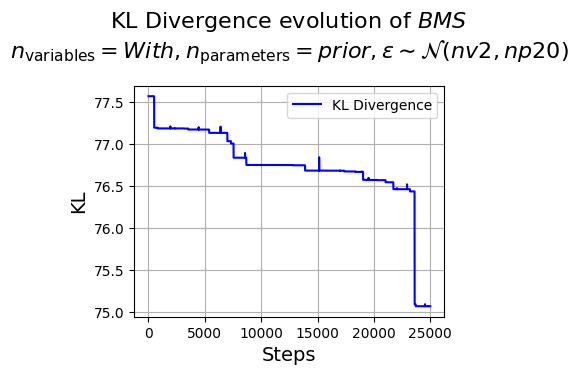

In [10]:
steps = np.arange(0,N+1,1)
KL = []

with open(new_filepath, 'r') as f:
    for line in f:
        KL.append(float(line.strip()))

steps = np.arange(0,len(KL),1)

# Name formatting
parts = filename_no_extension.split("_")
raw_function = parts[0]

# Plot formatting
function = raw_function.replace("**", "^").replace("*", "")

nvar = parts[1].replace("nv", "")  # Número de variables
nparam = parts[2].replace("np", "")  # Número de parámetros
mean = parts[3].replace("mean", "")  # Media
stddev = parts[4].replace("stddev", "")  # Desviación estándar

# LaTeX format title

title = rf"$\text{{KL Divergence evolution of }} {function}$ " + "\n" \
        rf"$n_{{\text{{variables}}}}={nvar}, n_{{\text{{parameters}}}}={nparam}, " \
        rf"\epsilon \sim \mathcal{{N}}({mean}, {stddev})$"

#title = "KL Divergence evolution of tree expressions generated with only the prior"
output_folder = "./KL/Figures/GAUSSIAN STEPS/"
output_filename = f"KL_evolution_{filename_no_extension}_GAUSSIAN_STEPS.png"
output_path = os.path.join(output_folder, output_filename)

plt.figure(figsize = (4,3))
plt.plot(steps, KL, label="KL Divergence", color="blue")
plt.xlabel("Steps", fontsize=14)
plt.ylabel("KL", fontsize=14)
plt.title(title, fontsize=16, pad=20)
plt.legend(loc="best", fontsize=10)
plt.grid(True)
plt.savefig(output_path, dpi = 150, bbox_inches = 'tight')


plt.show()


In [11]:
Tree_prob.root.prob_list

{'_a0_': 0.0396857594747342,
 '_a1_': 0.0396857594747342,
 '_a2_': 0.0396857594747342,
 '_a3_': 0.03916708180355304,
 '_a4_': 0.0396857594747342,
 '_a5_': 0.0396857594747342,
 '_a6_': 0.03929226567243237,
 '_a7_': 0.03873059857690154,
 '_a8_': 0.0396857594747342,
 '_a9_': 0.03652698809931202,
 '_a10_': 0.039281976792146074,
 '_a11_': 0.0396857594747342,
 '_a12_': 0.0396857594747342,
 'x': 0.030431679892387604,
 'z': 0.02188327106474601,
 'sin': 0.02579574365857722,
 'cos': 0.02579574365857722,
 'tan': 0.02579574365857722,
 'exp': 0.02579574365857722,
 'log': 0.021209445377046315,
 'sinh': 0.02579574365857722,
 'cosh': 0.021557799869414692,
 'tanh': 0.02579574365857722,
 'pow2': 0.020516608431995192,
 'pow3': 0.016906283607801578,
 'abs': 0.02579574365857722,
 'sqrt': 0.02579574365857722,
 'fac': 0.024512588269218618,
 '-': 0.02579574365857722,
 '+': 0.02579574365857722,
 '*': 0.022948412842245126,
 '/': 0.02579574365857722,
 '**': 0.02579574365857722}